# Extracted: Decision Tree code

This notebook contains only cells from the original `gpt.ipynb` that reference Decision Tree
implementation (imports, model creation, fit, predict, evaluation, visualization). If any
supporting preprocessing or data-loading cells are missing, you may need to copy them from
the original notebook to make this runnable.


### End-to-end Decision Tree inventory forecasting script

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
from datetime import datetime

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
import joblib

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SHAP may be heavy; import when needed
try:
    import shap
except Exception:
    shap = None

In [ ]:
# -----------------------------
# Helper metrics
# -----------------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return (np.fabs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100

In [ ]:
# -----------------------------
# Load data
# -----------------------------
DATA_PATH = '/content/drive/MyDrive/data/retail_store_inventory.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Please place the dataset in the same directory.")

In [ ]:
# read with low_memory=False to avoid dtype warnings
df = pd.read_csv(DATA_PATH, low_memory=False)
print('\nDataset loaded — shape:', df.shape)
print('\nColumns:', df.columns.tolist())


Dataset loaded — shape: (73100, 15)

Columns: ['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']


In [ ]:
# -----------------------------
# Quick inspection & assumptions
# -----------------------------
# Common columns that might exist: 'date', 'store_id', 'item_id', 'sales', 'price', 'competitor_price', 'is_promo'
# If your dataset uses different names, rename them here.

In [ ]:
# Auto-detect a date column more robustly
date_candidates = [c for c in df.columns if any(k in c.lower() for k in ['date', 'day', 'dt'])]
# prefer exact 'date' if present
if 'date' in [c.lower() for c in df.columns]:
    date_col = [c for c in df.columns if c.lower() == 'date'][0]
elif date_candidates:
    date_col = date_candidates[0]
else:
    raise ValueError('No date-like column detected. Please ensure your dataset has a date column.')

In [ ]:
print('\nUsing date column:', date_col)


Using date column: Date


In [ ]:
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
# drop rows with invalid dates
initial_len = len(df)
df = df.dropna(subset=[date_col])
print(f'Dropped {initial_len - len(df)} rows with invalid dates')

Dropped 0 rows with invalid dates


In [ ]:
# Identify target candidate columns for forecasting
possible_targets = [c for c in df.columns if any(k in c.lower() for k in ['sale','demand','qty','quantity','units','amount'])]
if len(possible_targets) == 0:
    raise ValueError('No target column (sales/demand/quantity) detected. Please check column names.')

In [ ]:
target_col = possible_targets[0]
print('Using target column:', target_col)

Using target column: Units Sold


In [ ]:
# Detect grouping columns (store, item/product)
group_cols = []
possible_store = [c for c in df.columns if 'store' in c.lower()]
possible_item = [c for c in df.columns if 'item' in c.lower() or 'product' in c.lower()]
if possible_store:
    group_cols.append(possible_store[0])
if possible_item:
    group_cols.append(possible_item[0])

In [ ]:
print('Detected group columns (will use when appropriate):', group_cols)

Detected group columns (will use when appropriate): ['Store ID', 'Product ID']


In [ ]:
# -----------------------------
# For demonstration: filter to a single store-item pair if group columns exist (you can remove this section to run on full data)
# -----------------------------
if len(group_cols) >= 1:
    grp = group_cols[0]
    top = df[grp].value_counts().index[0]
    print(f"Filtering to single {grp} = {top} for demo. Remove this if you want to model across all groups.")
    df = df[df[grp] == top].copy()

Filtering to single Store ID = S001 for demo. Remove this if you want to model across all groups.


In [ ]:
if len(group_cols) >= 2:
    grp2 = group_cols[1]
    top2 = df[grp2].value_counts().index[0]
    print(f"Further filtering to {grp2} = {top2} for demo.")
    df = df[df[grp2] == top2].copy()

Further filtering to Product ID = P0001 for demo.


In [ ]:
print('\nAfter filtering, shape:', df.shape)


After filtering, shape: (731, 15)


In [ ]:
# -----------------------------
# Sort by date
# -----------------------------
df = df.sort_values(date_col).reset_index(drop=True)

In [ ]:
# Basic missing value handling: for numeric columns, fill with median; for categorical: fill 'unknown'
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if date_col in cat_cols: cat_cols.remove(date_col)
if target_col in num_cols: num_cols.remove(target_col)

In [ ]:
print('Numeric cols (sample):', num_cols[:10])
print('Categorical cols (sample):', cat_cols[:10])

Numeric cols (sample): ['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
Categorical cols (sample): ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']


In [ ]:
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)
for c in cat_cols:
    df[c] = df[c].fillna('unknown')

In [ ]:
# If target has missing, drop those rows (can't train on missing target)
before = len(df)
df = df.dropna(subset=[target_col])
print(f'Dropped {before - len(df)} rows with missing target values')

Dropped 0 rows with missing target values


In [ ]:
# -----------------------------
# Feature engineering: date features, lags, rolling means
# -----------------------------
DF = df.copy()
DF['year'] = DF[date_col].dt.year
DF['month'] = DF[date_col].dt.month
DF['day'] = DF[date_col].dt.day
DF['dayofweek'] = DF[date_col].dt.dayofweek
DF['is_weekend'] = DF['dayofweek'].isin([5,6]).astype(int)
# week number using isocalendar() (works on pandas >= 1.1)
DF['weekofyear'] = DF[date_col].dt.isocalendar().week.astype(int)

In [ ]:
# Lag features
for lag in [1,2,3,7,14]:
    DF[f'{target_col}_lag_{lag}'] = DF[target_col].shift(lag)

In [ ]:
# Rolling windows
for window in [7,14,30]:
    DF[f'{target_col}_rolling_mean_{window}'] = DF[target_col].shift(1).rolling(window=window, min_periods=1).mean()

In [ ]:
# Price related lags if present
price_cols = [c for c in DF.columns if 'price' in c.lower()]
if price_cols:
    for pc in price_cols:
        for lag in [1,7]:
            DF[f'{pc}_lag_{lag}'] = DF[pc].shift(lag)

In [ ]:
# Competitor price difference if available
if 'competitor_price' in DF.columns and len(price_cols) > 0:
    DF['comp_price_diff'] = DF['competitor_price'] - DF[price_cols[0]]

In [ ]:
# Drop rows with NaNs created by shifting
DF = DF.dropna().reset_index(drop=True)
print('\nAfter feature engineering, shape:', DF.shape)


After feature engineering, shape: (717, 31)


In [ ]:
# -----------------------------
# Train/test split - time-based (last 20% as test)
# -----------------------------
cutoff_idx = int(len(DF) * 0.8)
train = DF.iloc[:cutoff_idx].copy()
test = DF.iloc[cutoff_idx:].copy()

In [ ]:
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 573, Test size: 144


In [ ]:
# Prepare features and target
exclude = [date_col, target_col] + group_cols
feature_cols = [c for c in DF.columns if c not in exclude]
print('Using features (sample):', feature_cols[:30])

Using features (sample): ['Category', 'Region', 'Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'weekofyear', 'Units Sold_lag_1', 'Units Sold_lag_2', 'Units Sold_lag_3', 'Units Sold_lag_7', 'Units Sold_lag_14', 'Units Sold_rolling_mean_7', 'Units Sold_rolling_mean_14', 'Units Sold_rolling_mean_30', 'Price_lag_1', 'Price_lag_7']


In [ ]:
X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

In [ ]:
# Identify categorical features among the selected features
categorical_feats = [c for c in feature_cols if c in cat_cols]
numeric_feats = [c for c in feature_cols if c not in categorical_feats]

In [ ]:
# Build ColumnTransformer flexibly depending on whether there are categorical features
ohe_kwargs = {'handle_unknown': 'ignore'}
# sklearn 1.4+ uses sparse_output, older versions use sparse
try:
    OneHotEncoder(sparse_output=False, **ohe_kwargs)
    ohe_use_kw = {'sparse_output': False}
except TypeError:
    ohe_use_kw = {'sparse': False}

In [ ]:
transformers = []
if numeric_feats:
    transformers.append(('num', 'passthrough', numeric_feats))
if categorical_feats:
    transformers.append(('cat', OneHotEncoder(**ohe_use_kw, handle_unknown='ignore'), categorical_feats))

In [ ]:
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [ ]:
# Build pipeline with DecisionTree
pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [ ]:
# Hyperparameter grid (kept modest to save time)
param_grid = {
    'model__max_depth': [3, 5, 8, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [ ]:
# TimeSeriesSplit for cross validation
n_splits = min(4, max(2, len(train)//50))  # adjust splits depending on data size
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
print('\nStarting GridSearchCV ... (this may take a while)')
grid.fit(X_train, y_train)
print('Grid search done. Best params:')
print(grid.best_params_)


Starting GridSearchCV ... (this may take a while)
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Grid search done. Best params:
{'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}


In [ ]:
# Best estimator
best = grid.best_estimator_

In [ ]:
# Evaluate on test
y_pred = best.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape_val = mape(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print('\nTest performance:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape_val:.2f}%')
print(f'R2: {r2:.4f}')


Test performance:
MAE: 8.7243
RMSE: 10.6063
MAPE: 17.71%
R2: 0.9900


In [ ]:
# Save metrics
metrics = {
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape_val,
    'R2': r2
}

In [ ]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('decision_tree_metrics.csv', index=False)

In [ ]:
# Save model
joblib.dump(best, 'decision_tree_model.joblib')
print('\nSaved model to decision_tree_model.joblib and metrics to decision_tree_metrics.csv')


Saved model to decision_tree_model.joblib and metrics to decision_tree_metrics.csv


In [ ]:
# Save predictions with dates
out = test[[date_col] + group_cols].copy()
out['y_true'] = y_test.values
out['y_pred'] = y_pred
out.to_csv('decision_tree_predictions.csv', index=False)
print('Saved predictions to decision_tree_predictions.csv')

Saved predictions to decision_tree_predictions.csv


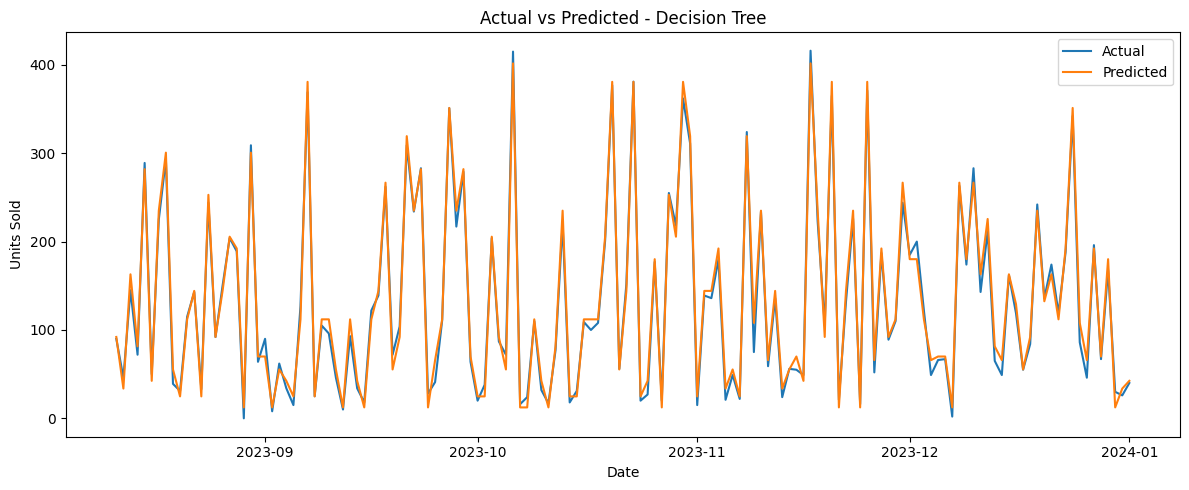

In [ ]:
# -----------------------------
# Plots: actual vs predicted
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(out[date_col], out['y_true'], label='Actual')
plt.plot(out[date_col], out['y_pred'], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted - Decision Tree')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

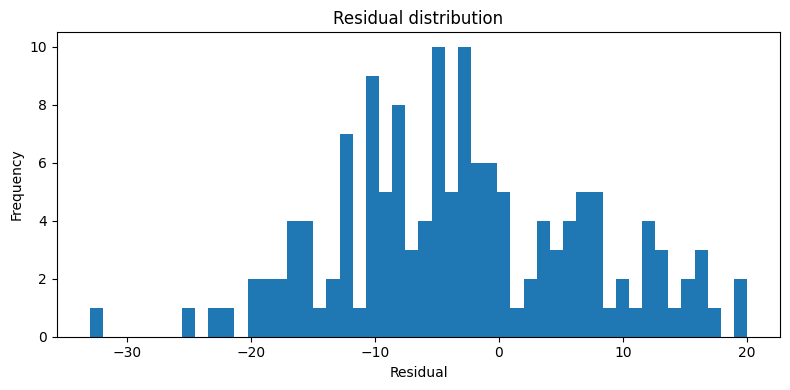

In [ ]:
# Residuals
res = out['y_true'] - out['y_pred']
plt.figure(figsize=(8,4))
plt.hist(res, bins=50)
plt.title('Residual distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('residuals_hist.png')
plt.show()

In [ ]:
# -----------------------------
# SHAP explainability (TreeExplainer)
# -----------------------------
if shap is None:
    print('\nSHAP is not installed. To run SHAP, install it with: pip install shap')
else:
    # Get preprocessor and model separately
    preproc = best.named_steps['preproc']
    model = best.named_steps['model']

In [ ]:
    # Transform training data to feature array used by the model
    X_train_transformed = preproc.transform(X_train)
    X_test_transformed = preproc.transform(X_test)

In [ ]:
    # Build feature names after OneHotEncoding
    feature_names = []
    feature_names += numeric_feats
    if categorical_feats:
        ohe = preproc.named_transformers_.get('cat')
        if ohe is not None:
            cats = ohe.categories_
            for col, categories in zip(categorical_feats, cats):
                for cat in categories:
                    feature_names.append(f'{col}__{cat}')

In [ ]:
    # SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_transformed)

In [ ]:
    # Summary plot (save as PNG)
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=150)
    plt.close()
    print('Saved SHAP summary to shap_summary.png')

Saved SHAP summary to shap_summary.png


In [ ]:
    # Example dependence plot for top feature
    try:
        top_feat = np.argsort(np.abs(shap_values).mean(0))[-1]
        top_name = feature_names[top_feat]
        shap.dependence_plot(top_name, shap_values, X_test_transformed, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig('shap_dependence_top.png', dpi=150)
        plt.close()
        print('Saved SHAP dependence for top feature to shap_dependence_top.png')
    except Exception as e:
        print('Could not create SHAP dependence plot:', e)

Saved SHAP dependence for top feature to shap_dependence_top.png


In [ ]:
# -----------------------------
# Optional: small Streamlit dashboard (commented out). To run: streamlit run this_script.py
# -----------------------------
# import streamlit as st
# st.title('Decision Tree Inventory Forecasting - Demo')
# st.write('Model metrics:')
# st.table(metrics_df)
# st.line_chart(out.set_index(date_col)[['y_true','y_pred']])

In [ ]:
print('\nAll done. Check generated files in the working directory:')
print(' - decision_tree_model.joblib\n - decision_tree_metrics.csv\n - decision_tree_predictions.csv\n - actual_vs_predicted.png\n - residuals_hist.png\n - shap_summary.png (if SHAP installed)')


All done. Check generated files in the working directory:
 - decision_tree_model.joblib
 - decision_tree_metrics.csv
 - decision_tree_predictions.csv
 - actual_vs_predicted.png
 - residuals_hist.png
 - shap_summary.png (if SHAP installed)
